# Installs, Imports, Drive Connection, WandB Connection

##### Installs

In [1]:
!pip install transformers==4.10.0
# !pip install git+https://github.com/huggingface/transformers.git
!pip install datasets==1.9.0
!pip install -U PyYAML
# !pip install "ray[default]"
!pip install wandb
!pip install tensorboardX

     |████████████████████████████████| 2.8 MB 8.0 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 52.8 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
     |████████████████████████████████| 895 kB 61.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 262 kB 7.1 MB/s 
     |████████████████████████████████| 125 kB 74.2 MB/s 
     |████████████████████████████████| 243 kB 42.9 MB/s 
     |████████████████████████████████| 1.7 MB 7.1 MB/s 
     |████████████████████████████████| 180 kB 37.4 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 139 kB 48.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=57144ca7b6

##### Imports

In [2]:
import sys
import os
import numpy as np
# from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
import torch
from pathlib import Path
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import math
from transformers import AutoModelForSequenceClassification

In [ ]:
import os
import pickle
import numpy as np

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import MedianStoppingRule # PopulationBasedTraining, ASHAScheduler
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger

from transformers import DistilBertConfig

from ray.tune.integration.wandb import WandbLoggerCallback
# from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification

##### Drive Connection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Get Configuration

In [16]:
import configparser
import sys
from pathlib import Path

config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/Thesis/BookSuccessPredictor/config.ini')

drive_base_path = Path(config['Drive']['drive_base_path'])

sys.path.append(str(drive_base_path / 'BookSuccessPredictor' / '_utils'))

In [17]:
print("Using Model:", config['Model']['name'])
print("With NERed Dataset:", config['Model']['use_ner'])
print("In multi-task setting:", config['Model']['multi_task'])
print("Using overlap tokenizer:", config['Tokenizer']['overlap'])
if eval(config['Tokenizer']['overlap']):
  print("Using overlap of:", config['Tokenizer']['overlap_amt'])
print("Using max segments:", config['Tokenizer']['max_segments'])
print("Using pretrained model:", config['WandB']['use_WandB_pretrained'])
if eval(config['WandB']['use_WandB_pretrained']):
  print("Using pretrain type:", config['WandB']['pretrain_type'])
print("Training on the success task:", config['Model']['on_success_label'])

Using Model: distilbert-base-uncased
With NERed Dataset: True
In multi-task setting: True
Using overlap tokenizer: True
Using overlap of: 25
Using max segments: 1
Using pretrained model: True
Using pretrain type: 3
Training on the success task: False


##### WandB Connection

In [6]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
%env WANDB_PROJECT=goodreads_success_predictor_80_20

env: WANDB_LOG_MODEL=true
env: WANDB_PROJECT=goodreads_success_predictor_80_20


In [7]:
wandb.login(key = config['WandB']['api_key'])

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Dataset Generator

### Load Text Data

#### goodreads_maharjan

In [ ]:
if eval(config['Model']['use_ner']):
  base_path = Path(config['Datasets']['nered_goodreads_maharjan_path'])
  full_path = base_path / 'loading_script_nered.py'
else:
  base_path = Path(config['Datasets']['goodreads_maharjan_path'])
  full_path = base_path / 'loading_script_trimmed.py'
dataset = load_dataset(str(full_path))

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset good_reads_practice_dataset downloaded and prepared to /root/.cache/huggingface/datasets/good_reads_practice_dataset/main_domain/1.1.0/fee2eb60ac7713af6f776b7c4dab63145144f749e5689ea3dc2299235f6f560e. Subsequent calls will reuse this data.


In [ ]:
full_path

PosixPath('/content/drive/MyDrive/Thesis/BookSuccessPredictor/datasets/goodreads_maharjan_super/raw_preprocessed/trimmed_and_nered/loading_script_nered.py')

#### goodreads_guarro

In [ ]:
base_path = config['Datasets']['nered_goodreads_guarro_path']
dataset = load_dataset(base_path)

### Custom Tokenization Process

##### Get Tokenizer

In [8]:
from transformers import AutoTokenizer

In [9]:
print("Using tokenizer of ", config['Model']['name'])
if eval(config['Model']['use_ner']):
  print("adding special token for [CHARACTER]")
  # tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base', additional_special_tokens = ['[CHARACTER]'])
  tokenizer = AutoTokenizer.from_pretrained(config['Model']['name'], additional_special_tokens = ['[CHARACTER]'])
else:
  tokenizer = AutoTokenizer.from_pretrained(config['Model']['name'])

Using tokenizer of  distilbert-base-uncased
adding special token for [CHARACTER]


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


##### Do actual tokenizing and uploading

In [ ]:
from tokenization_algos import chunk_and_encode_examples_w_complete_sentences, chunk_and_encode_examples_w_overlap

In [ ]:
from functools import partial
encode_algo = partial(chunk_and_encode_examples_w_overlap, tokenizer=tokenizer, stride=75)
# encode_algo = partial(chunk_and_encode_examples_w_complete_sentences, tokenizer=tokenizer)

In [ ]:
chunked_encoded_dataset = dataset.map(encode_algo, remove_columns=dataset.column_names['train'], batched = True)

  0%|          | 0/1 [00:00<?, ?ba/s]

tokenizing with max length: 512 and stride: 75


  0%|          | 0/1 [00:00<?, ?ba/s]

tokenizing with max length: 512 and stride: 75


  0%|          | 0/1 [00:00<?, ?ba/s]

tokenizing with max length: 512 and stride: 75


When uploading the tokenized datasets to Drive, we may need to break them up into as many pieces as is necessary. Otherwise the serialization and uploading fails. In my case I had to split each subset (train, val, test) into 2 parts. If using tokenization with complete sentences, we can usually avoid this hack. Otherwise with overlap, the dataset will most likely be too large and this trick may be necessary.

In [ ]:
num_parts = 2

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for split in ['train', 'validation', 'test']:
  prefix = 'val' if split == 'validation' else split
  num_chunks = chunked_encoded_dataset[split].num_rows
  step = num_chunks // num_parts
  folder_id = '1frJ_jt8muWMlea2k_z_tlsfmE3vjhF2T'
  for i in range(num_parts):
    print(i)
    filename = prefix + '_dataset' + str(i) + '.pkl'
    if i == num_parts - 1:
      dumpme = chunked_encoded_dataset[split][step*i:]
    else:
      dumpme = chunked_encoded_dataset[split][step*i:step*(i+1)]
    
    with open(filename, 'wb') as output_file:
      pickle.dump(dumpme, output_file)

    file = drive.CreateFile({'parents':[{u'id': folder_id}]})
    file.SetContentFile(filename)
    file.Upload()

0
1
0
1
0
1


#### Loading

In [10]:
load_path = Path(config['Drive']['drive_base_path']) / 'BookSuccessPredictor' / 'datasets' / 'goodreads_maharjan_super' / 'already_tokenized'

In [11]:
split_folder = '80_20' if config['Datasets']['split'] == '80_20' else '60_40'
load_path = load_path / split_folder

preprocess_folder = 'NERed' if eval(config['Model']['use_ner']) else 'Standard'
load_path = load_path / preprocess_folder

tokenizer_folder = 'OverlapTokenizer' + '/' + config['Tokenizer']['overlap_amt'] if eval(config['Tokenizer']['overlap']) else 'SentenceTokenizer'
load_path = load_path / tokenizer_folder

del split_folder, preprocess_folder, tokenizer_folder

In [12]:
import re
model_folder = config['Model']['name']
model_folder = model_folder.replace('-base', '')
model_folder = re.sub(r'.*/*(?=\/)\/','', model_folder) # .*/*(?=\\)\\
load_path = load_path / model_folder

In [13]:
load_path

PosixPath('/content/drive/MyDrive/Thesis/BookSuccessPredictor/datasets/goodreads_maharjan_super/already_tokenized/80_20/NERed/OverlapTokenizer/25/distilbert-uncased')

In [14]:
from datasets import DatasetDict, Dataset, concatenate_datasets
train_paths = [f for f in os.listdir(load_path) if f.startswith('train')]
val_paths = [f for f in os.listdir(load_path) if f.startswith('val')]
test_paths = [f for f in os.listdir(load_path) if f.startswith('test')]

train_datasets = []
val_datasets = []
test_datasets = []

for trainp in train_paths:
  with open(load_path / trainp, "rb") as input_file:
    train_datasets.append(Dataset.from_dict(pickle.load(input_file)))

for valp in val_paths:
  with open(load_path / valp, "rb") as input_file:
    val_datasets.append(Dataset.from_dict(pickle.load(input_file)))

for testp in test_paths:
  with open(load_path / testp, "rb") as input_file:
    test_datasets.append(Dataset.from_dict(pickle.load(input_file)))

train_dataset = concatenate_datasets(train_datasets)
del train_datasets

val_dataset = concatenate_datasets(val_datasets)
del val_datasets

test_dataset = concatenate_datasets(test_datasets)
del test_datasets

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

In [46]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 20429
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 4974
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10269
    })
})

In [15]:
if (eval(config['Model']['multi_task'])):
  print('multitask')
  # When batched = True, we take in multiple examples
  def group_success_and_genre(examples):
    examples['labels'] = np.vstack((examples['success_label'], examples['genre'])).T
    return examples

  chunked_encoded_dataset = chunked_encoded_dataset.map(group_success_and_genre, batched = True, remove_columns=['genre', 'success_label'])
else:
  print('single task')
  if (eval(config['Model']['on_success_label'])):
    print("on success label")
    chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')
  else:
    print("on genre")
    chunked_encoded_dataset = chunked_encoded_dataset.rename_column('genre', 'labels')

multitask


  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

#Dataset Exploration

In [19]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 20429
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 4974
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 10269
    })
})

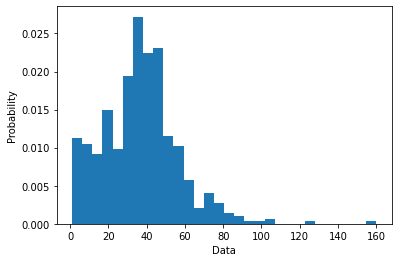

In [18]:
import matplotlib.pyplot as plt
import itertools

num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [19]:
# [(g[0], len(list(g[1]))) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]
start_of_segmented_book = {}
last_idx = 0
for g in itertools.groupby(chunked_encoded_dataset['train']['book_title']):
  start_of_segmented_book[g[0]] = last_idx
  last_idx = len(list(g[1])) + last_idx

In [20]:
max_num_segments = eval(config['Tokenizer']['max_segments'])

In [21]:
# When batched = True, we take in multiple examples
def filter_segments(example, idx):
  if (idx - start_of_segmented_book[example['book_title']] < max_num_segments):
    return True
  else:
    return False

test = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

  0%|          | 0/21 [00:00<?, ?ba/s]

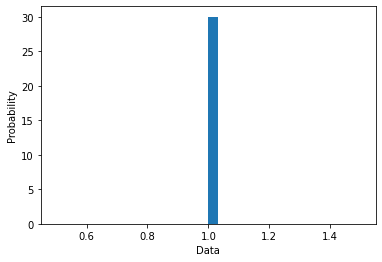

In [22]:
num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(test['book_title'])]

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [23]:
chunked_encoded_dataset['train'] = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

  0%|          | 0/21 [00:00<?, ?ba/s]

## Transformer --> Classification

In [ ]:
# db_config_base = DistilBertConfig.from_pretrained('/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained')
# # db_config_base.update({'_name_or_path': '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained', 'alpha': 0.2, 'dropout': 0.8})
# return DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config_base._name_or_path, config = db_config_base)

In [ ]:
pretrained_model_name_or_path

'./artifacts/model-ukrei3n1:v0'

In [25]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
from transformers import DistilBertConfig
# from transformers import RobertaForSequenceClassification

# pretrained_model_name_or_path = '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained'
# pretrained_model_name_or_path = '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/3vvi0uoqDistilBertModel'

if (eval(config['WandB']['use_WandB_pretrained'])):
  print("Checking pretrained models")
  run = wandb.init()
  if (eval(config['WandB']['pretrain_type']) == 2): # pretrained on guarro (in-domain)
    print("Checking pretrained on guarro dataset")
    if (eval(config['Model']['use_ner'])):
      print("Checking pretrained on NERed preprocessed version")
      if config['Model']['name'] == 'bert-base-uncased':
        print("Using in-domain pretrained bert")
        artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_mlm/model-1iwvq3zs:v0', type='model')
      elif config['Model']['name'] == 'distilbert-base-uncased':
        print("Using in-domain pretrained distilbert")
        artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_mlm/model-5v9y1o6j:v0', type='model')
    else: # do not use character masking
      print("Checking pretrained on non character masked version")
      if config['Model']['name'] == 'bert-base-uncased':
        print("Using pretrained bert")
        artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_mlm/model-15xre9nx:v0', type='model')
  elif (eval(config['WandB']['pretrain_type']) == 1): # pretrained on maharjan (within-task)
    print("Checking pretrained on maharjan dataset")
    if (eval(config['Model']['use_ner'])):
      print("Checking pretrained on NERed preprocessed version")
      if config['Model']['name'] == 'distilbert-base-uncased':
        print("Using within-task pretrained distilbert")
        artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_mlm/model-88y1a1x3:v0', type='model')
  elif (eval(config['WandB']['pretrain_type']) == 3):
    print("Checking pretrained on guarro&maharjan dataset")
    if (eval(config['Model']['use_ner'])):
      print("Checking pretrained on NERed preprocessed version")
      if config['Model']['name'] == 'distilbert-base-uncased':
        print("Using in-domain then within-task pretrained distilbert")
        artifact = run.use_artifact('lucaguarro/goodreads_pretrained_models/model-ukrei3n1:v0', type='model')
  elif (eval(config['WandB']['pretrain_type']) == 7):
    print("Checking pretrained on guarro&maharjan&genre")
    if (eval(config['Model']['use_ner'])):
      if config['Model']['name'] == 'distilbert-base-uncased':
        print("Using in-domain then within-task then genre pretrained distilbert")
        artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-2db78qsf:v0', type='model')
  pretrained_model_name_or_path = artifact.download()
else:
  print("Not using further pretrained models")
  pretrained_model_name_or_path = config['Model']['name']

if (eval(config['Model']['multi_task'])):
  metric_for_best_model = 'eval_s_f1'
  greater_is_better = True
  if (config['Model']['name'] == 'distilbert-base-uncased'):
    from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
    db_config = DistilBertConfig.from_pretrained(pretrained_model_name_or_path)
    db_config.update({'_name_or_path': pretrained_model_name_or_path, 'alpha': 0.5}) # 'alpha': 0.5928, 'attention_dropout': 0.2436, 'dropout': 0.3}) # 'dropout': 0.3877
    print(db_config)
    model = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)
  else:
    from MultiTaskExtensions import BertForMultipleSequenceClassification
    model = BertForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path)
else:
  print("Single task model", pretrained_model_name_or_path)
  # model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name_or_path)
  if eval(config['Model']['on_success_label']):
    metric_for_best_model = 'eval_f1'
    greater_is_better = True
    print("num labels is 2")
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path)
  else:
    metric_for_best_model = 'eval_loss'
    greater_is_better = False
    print("num labels is 8")
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path, num_labels = 8)
  model.resize_token_embeddings(len(tokenizer))

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


Checking pretrained models


Checking pretrained on guarro&maharjan dataset
Checking pretrained on NERed preprocessed version
Using in-domain then within-task pretrained distilbert


wandb: Downloading large artifact model-ukrei3n1:v0, 255.57MB. 3 files... Done. 0:0:0


DistilBertConfig {
  "_name_or_path": "./artifacts/model-ukrei3n1:v0",
  "activation": "gelu",
  "alpha": 0.5,
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30523
}

2 8


Some weights of the model checkpoint at ./artifacts/model-ukrei3n1:v0 were not used when initializing DistilBERTForMultipleSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBERTForMultipleSequenceClassification were not initialized from the model checkpoint at ./artifacts/model-ukrei3n1:v0 and are newly initialized: ['classifier

In [26]:
from scores import compute_metrics_multi, compute_metrics_single
if eval(config['Model']['multi_task']):
  print('multi')
  # from scores import compute_metrics_multi
  compute_metrics = compute_metrics_multi
else:
  print('single')
  # from scores import compute_metrics_single
  compute_metrics = compute_metrics_single

multi


In [27]:
run_title = config['Model']['name'] + ":"
run_title = run_title + 'NER:' if eval(config['Model']['use_ner']) else run_title + 'Standard:'
run_title = run_title + 'overlap' + str(config['Tokenizer']['overlap_amt']) + ':' if eval(config['Tokenizer']['overlap']) else run_title + 'sentence:'
run_title = run_title + 'MaxLen' + str(config['Tokenizer']['max_len']) + ':' 
run_title = run_title + 'MaxSegments' + str(config['Tokenizer']['max_segments']) + ":" if eval(config['Tokenizer']['max_segments']) else run_title
pretrained = 'NoPretraining:'
if eval(config['WandB']['use_WandB_pretrained']):
  pretrained = 'pretrainedOn'
  if eval(config['WandB']['pretrain_type']) == 1:
    pretrained += 'Maharjan:'
  elif eval(config['WandB']['pretrain_type']) == 2:
    pretrained += 'Guarro:'
  elif eval(config['WandB']['pretrain_type']) == 3:
    pretrained += 'Guarro&Maharjan:'
  elif eval(config['WandB']['pretrain_type']) == 7:
    pretrained += 'Guarro&Maharjan&Genre:'
run_title += pretrained 
run_title = run_title + 'multi_task' if eval(config['Model']['multi_task']) else run_title + 'single_task'
if not(eval(config['Model']['multi_task'])):
  run_title = run_title + '_success' if eval(config['Model']['on_success_label']) else run_title + '_genre'

In [28]:
# run_title = run_title + ':9epochs:1e-4lr'
run_title

'distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments1:pretrainedOnGuarro&Maharjan:multi_task'

In [30]:
%env WANDB_PROJECT=goodreads_success_predictor_80_20

training_args = TrainingArguments(
    run_title,
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    learning_rate=5e-5,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=5,
    # gradient_accumulation_steps=2,
    evaluation_strategy = "steps",
    eval_steps = 5, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = metric_for_best_model,
    greater_is_better = greater_is_better,
    report_to = "wandb",
    save_total_limit = 5
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

env: WANDB_PROJECT=goodreads_success_predictor_80_20


The following columns in the training set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running training *****
  Num examples = 555
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 175
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,S Accuracy,S F1,S Precision,S Recall,G Accuracy,G F1,G Precision,G Recall
5,1.361700,1.322744,0.689184,0.562371,0.474974,0.689184,0.689184,0.066576,0.041254,0.172899
10,1.313000,1.296282,0.693205,0.603159,0.651925,0.693205,0.693205,0.051885,0.039374,0.163048
15,1.211400,1.255652,0.692400,0.604011,0.648577,0.692400,0.692400,0.044152,0.078055,0.158826
20,1.195200,1.236950,0.713711,0.664355,0.690407,0.713711,0.713711,0.065078,0.040273,0.169883
25,1.221300,1.260854,0.600322,0.615007,0.659706,0.600322,0.600322,0.063482,0.039651,0.166466
30,1.248500,1.192079,0.704664,0.633114,0.680380,0.704664,0.704664,0.095393,0.072863,0.186771
35,1.175000,1.149892,0.715722,0.660426,0.696952,0.715722,0.715722,0.100201,0.077667,0.207680
40,1.126100,1.126989,0.706675,0.684090,0.683200,0.706675,0.706675,0.125451,0.095293,0.224568
45,1.028300,1.114950,0.719140,0.689068,0.696679,0.719140,0.719140,0.122948,0.090263,0.217732
50,1.009300,1.123749,0.722758,0.687469,0.701970,0.722758,0.722758,0.115694,0.086834,0.213108


The following columns in the evaluation set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Evaluation *****
  Num examples = 4974
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments1:pretrainedOnGuarro&Maharjan:multi_task/checkpoint-5
Configuration saved in distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments1:pretrainedOnGuarro&Maharjan:multi_task/checkpoint-5/config.json
Model weights saved in distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments1:pretrainedOnGuarro&Maharjan:multi_task/checkpoint-5/pytor

TrainOutput(global_step=175, training_loss=0.9019461727142334, metrics={'train_runtime': 1742.3898, 'train_samples_per_second': 1.593, 'train_steps_per_second': 0.1, 'total_flos': 367649475840000.0, 'train_loss': 0.9019461727142334, 'epoch': 5.0})

## Scorer

In [ ]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
from scores import ModelScorer

In [ ]:
run = wandb.init()
# artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-3igwy2id:v0', type='model')
artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-3vvi0uoq:v0', type='model')
artifact_dir = artifact.download()

In [ ]:
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)

In [ ]:
m_scorer.get_segmented_f1_scores()

In [ ]:
m_scorer.get_book_f1_scores()

running experiments

##### bert scorers

bert-base-uncased Standard Overlap0 MaxLen512 NoPretraining SingleTask

In [ ]:
from scores import ModelScorer

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-l20bzyr9:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_Standard, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

bert-base-uncased NERedDataset overlap0 MaxLen512 NoPretraining single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-34r86bs1:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_NERed, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

bert-base-uncased Standard overlap0 MaxLen512 pretrainedOnGuarro single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3ji0xbmc:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_Standard, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

bert-base-uncased-NER:overlap0-MaxLen512-pretrainedOnGuarro-single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-lyrc1875:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_NERed, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

##### distilbert scorers

distilbert-base-uncased-Standard-overlap0-MaxLen512-NoPretraining-single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-22umyx6j:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:sentence:MaxLen512:NoPretraining:single_task_success

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3rxadujj:v0', type='model')
artifact_dir = artifact.download()

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: book_title, token_type_ids, genre.
***** Running Prediction *****
  Num examples = 4701
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: book_title, token_type_ids, genre.
***** Running Prediction *****
  Num examples = 9712
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.6948113423825935 using a threshold of 0.5400000000000001 

The max weighted f1 score is 0.6872353014431374 with a threshold of 0.5000000000000001 



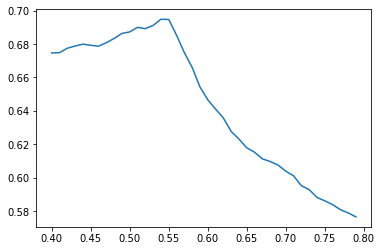

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6515642446722917 using the validated threshold of 0.5400000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7395338829135283 using a threshold of 0.5500000000000002 

The max weighted f1 score is 0.7326425379718784 with a threshold of 0.5000000000000001 



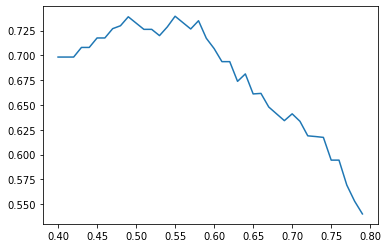

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6724062205888943 using a threshold of 0.5 

The weighted f1 score is 0.6760540574924679 using the validated threshold of 0.5500000000000002 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased-NER:overlap0-MaxLen512-NoPretraining-single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-vqy3ynmx:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-vqy3ynmx:v0, 255.46MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model
)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4737
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 9758
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7041670571261526 using a threshold of 0.5400000000000001 

The max weighted f1 score is 0.6949280873771967 with a threshold of 0.5000000000000001 



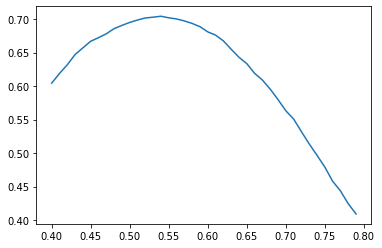

*****SCORE ON TEST SET*****
The weighted f1 score is 0.661668715836823 using the validated threshold of 0.5400000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7374265171830836 using a threshold of 0.5300000000000001 

The max weighted f1 score is 0.7080771638846559 with a threshold of 0.5000000000000001 



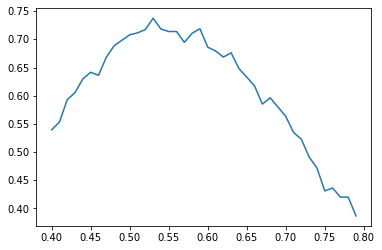

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6450603122459407 using a threshold of 0.5 

The weighted f1 score is 0.6689999946129107 using the validated threshold of 0.5300000000000001 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap50:MaxLen512:NoPretraining:single_task_success

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-znrfybc6:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-znrfybc6:v0, 255.46MB. 3 files... Done. 0:0:0


In [ ]:
trainer = Trainer(
    model=model
)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 5236
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 10816
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7066558773825518 using a threshold of 0.5000000000000001 

The max weighted f1 score is 0.7066558773825518 with a threshold of 0.5000000000000001 



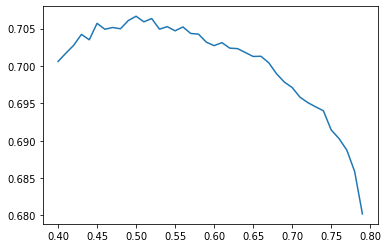

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6439987044862702 using the validated threshold of 0.5000000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7448353435821526 using a threshold of 0.6400000000000002 

The max weighted f1 score is 0.7207526286662979 with a threshold of 0.5000000000000001 



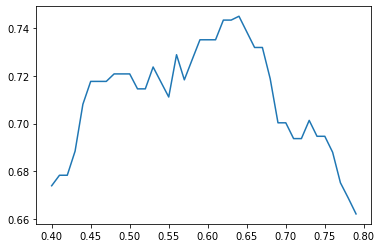

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6450738486178597 using a threshold of 0.5 

The weighted f1 score is 0.6605111085821225 using the validated threshold of 0.6400000000000002 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_50, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap100:MaxLen512:NoPretraining:single_task_success

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3bo5zigu:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-3bo5zigu:v0, 255.46MB. 3 files... Done. 0:0:0
loading configuration file ./artifacts/model-3bo5zigu:v0/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30523
}

loading weights file ./artifacts/model-3bo5zigu:v0/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSeq

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 5865
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 12117
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7009244680200563 using a threshold of 0.4900000000000001 

The max weighted f1 score is 0.7007122811831689 with a threshold of 0.5000000000000001 



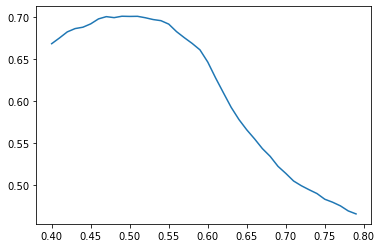

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6567145085276751 using the validated threshold of 0.4900000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7326425379718784 using a threshold of 0.4800000000000001 

The max weighted f1 score is 0.7287695616702514 with a threshold of 0.5000000000000001 



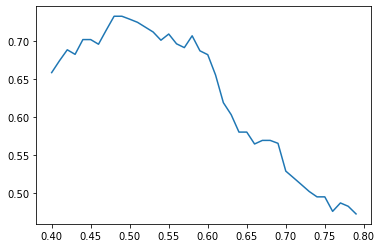

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6934311579963056 using a threshold of 0.5 

The weighted f1 score is 0.6850680255281255 using the validated threshold of 0.4800000000000001 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_100, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap0:MaxLen512:pretrainedOnMaharjan:single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-1aect73h:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4737
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 9758
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.714661458090182 using a threshold of 0.5700000000000002 

The max weighted f1 score is 0.7026379996331937 with a threshold of 0.5000000000000001 



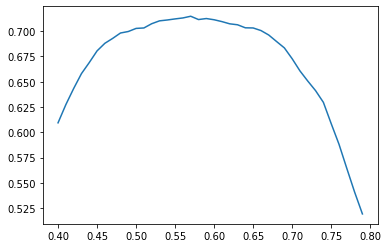

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6536360291976662 using the validated threshold of 0.5700000000000002 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7497287276561729 using a threshold of 0.5800000000000002 

The max weighted f1 score is 0.7207526286662979 with a threshold of 0.5000000000000001 



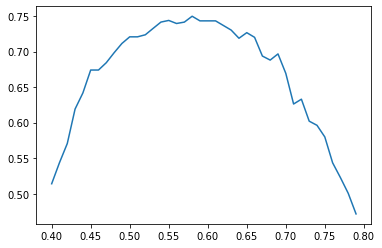

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6381757508342604 using a threshold of 0.5 

The weighted f1 score is 0.6688552587700783 using the validated threshold of 0.5800000000000002 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased-NER:overlap0-MaxLen512-pretrainedOnGuarro-single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-2p3smgob:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4737
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 9758
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7037565581926282 using a threshold of 0.5100000000000001 

The max weighted f1 score is 0.6993635387537334 with a threshold of 0.5000000000000001 



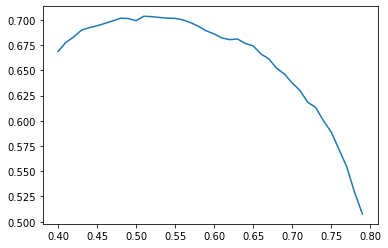

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6707764252425839 using the validated threshold of 0.5100000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7317918572820777 using a threshold of 0.5900000000000002 

The max weighted f1 score is 0.7199978663964102 with a threshold of 0.5000000000000001 



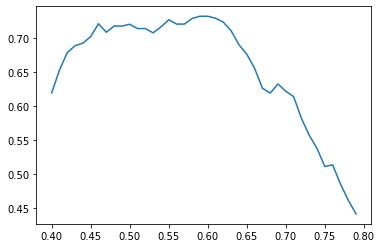

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6821344314331059 using a threshold of 0.5 

The weighted f1 score is 0.6771969999556207 using the validated threshold of 0.5900000000000002 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap0:MaxLen512:pretrainedOnGuarro&Maharjan:single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3fqdlh9x:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4737
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: genre, token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 9758
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7142581552815018 using a threshold of 0.5100000000000001 

The max weighted f1 score is 0.7128626320420494 with a threshold of 0.5000000000000001 



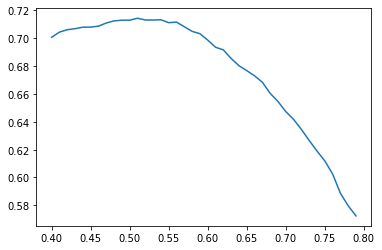

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6573537146636875 using the validated threshold of 0.5100000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7459741509118287 using a threshold of 0.4900000000000001 

The max weighted f1 score is 0.7395338829135283 with a threshold of 0.5000000000000001 



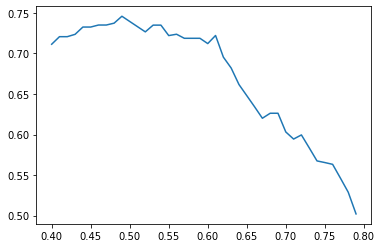

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6748551364786561 using a threshold of 0.5 

The weighted f1 score is 0.6629865900383143 using the validated threshold of 0.4900000000000001 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap0:MaxLen512:pretrainedOnGuarro&Maharjan:multi_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-2hoynmwy:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-2hoynmwy:v0, 255.48MB. 3 files... Done. 0:0:0


2 8


In [ ]:
trainer = Trainer(
    model=model
)

The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 4737
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 9758
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7213922840293344 using a threshold of 0.5100000000000001 

The max weighted f1 score is 0.7200887594628317 with a threshold of 0.5000000000000001 



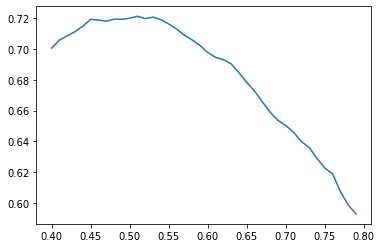

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6562032701270113 using the validated threshold of 0.5100000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7644505672058098 using a threshold of 0.5100000000000001 

The max weighted f1 score is 0.7609168479170152 with a threshold of 0.5000000000000001 



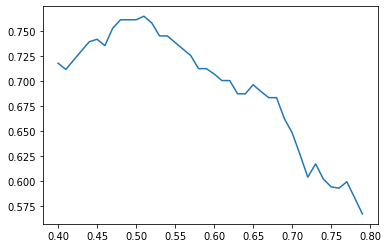

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6688552587700783 using a threshold of 0.5 

The weighted f1 score is 0.6701570881226053 using the validated threshold of 0.5100000000000001 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_multi, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap25:MaxLen512:pretrainedOnGuarro&Maharjan:multi_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3qw9orft:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4974
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 10269
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7283420932894868 using a threshold of 0.5700000000000002 

The max weighted f1 score is 0.7275295433469162 with a threshold of 0.5000000000000001 



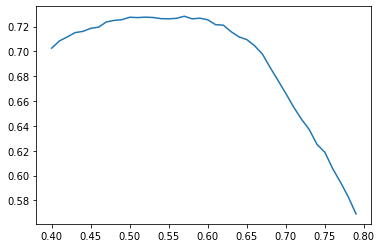

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6963641702374088 using the validated threshold of 0.5700000000000002 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7773915128266603 using a threshold of 0.5400000000000001 

The max weighted f1 score is 0.7407500000000001 with a threshold of 0.5000000000000001 



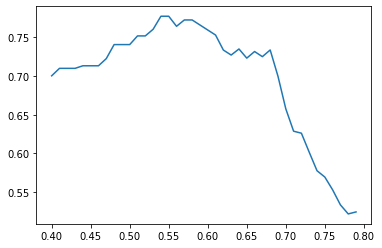

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6775465498357064 using a threshold of 0.5 

The weighted f1 score is 0.6939571880726303 using the validated threshold of 0.5400000000000001 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_25, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap50:MaxLen512:pretrainedOnGuarro&Maharjan:multi_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-22ktxt8q:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 5236
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 10816
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7309458789792368 using a threshold of 0.5300000000000001 

The max weighted f1 score is 0.7281928265400899 with a threshold of 0.5000000000000001 



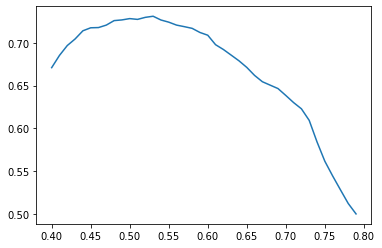

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6719754194742881 using the validated threshold of 0.5300000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.757902275464696 using a threshold of 0.5300000000000001 

The max weighted f1 score is 0.7544176610327553 with a threshold of 0.5000000000000001 



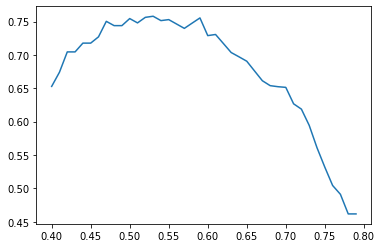

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6529054136338514 using a threshold of 0.5 

The weighted f1 score is 0.6773275862068966 using the validated threshold of 0.5300000000000001 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_50, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap75:MaxLen512:pretrainedOnGuarro&Maharjan:multi_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-2ifwcbkg:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-2ifwcbkg:v0, 255.48MB. 3 files... Done. 0:0:0
loading configuration file ./artifacts/model-2ifwcbkg:v0/config.json
Model config DistilBertConfig {
  "_name_or_path": "./artifacts/model-ukrei3n1:v0",
  "activation": "gelu",
  "alpha": 0.5,
  "architectures": [
    "DistilBERTForMultipleSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30523
}

loading weights file ./artifacts/model-2ifwcbkg:v0/pytorch_model.bin


2 8


All model checkpoint weights were used when initializing DistilBERTForMultipleSequenceClassification.

All the weights of DistilBERTForMultipleSequenceClassification were initialized from the model checkpoint at ./artifacts/model-2ifwcbkg:v0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBERTForMultipleSequenceClassification for predictions without further training.


In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 5538
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 11426
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7330002989965712 using a threshold of 0.5300000000000001 

The max weighted f1 score is 0.7265993597571874 with a threshold of 0.5000000000000001 



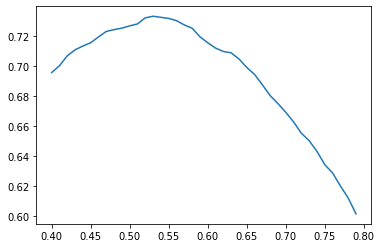

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6732235063634404 using the validated threshold of 0.5300000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7643939393939395 using a threshold of 0.5300000000000001 

The max weighted f1 score is 0.7541176470588237 with a threshold of 0.5000000000000001 



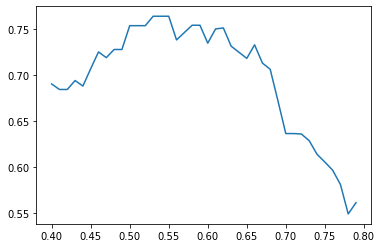

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6699376747561419 using a threshold of 0.5 

The weighted f1 score is 0.6829939227735174 using the validated threshold of 0.5300000000000001 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_75, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()


distilbert-base-uncased:NER:overlap100:MaxLen512:pretrainedOnGuarro&Maharjan:multi_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3lexvbip:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-3lexvbip:v0, 255.48MB. 3 files... Done. 0:0:0
loading configuration file ./artifacts/model-3lexvbip:v0/config.json
Model config DistilBertConfig {
  "_name_or_path": "./artifacts/model-ukrei3n1:v0",
  "activation": "gelu",
  "alpha": 0.5,
  "architectures": [
    "DistilBERTForMultipleSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30523
}

loading weights file ./artifacts/model-3lexvbip:v0/pytorch_model.bin


2 8


All model checkpoint weights were used when initializing DistilBERTForMultipleSequenceClassification.

All the weights of DistilBERTForMultipleSequenceClassification were initialized from the model checkpoint at ./artifacts/model-3lexvbip:v0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBERTForMultipleSequenceClassification for predictions without further training.


In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 5865
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 12117
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7318472566291477 using a threshold of 0.5900000000000002 

The max weighted f1 score is 0.7147817098773042 with a threshold of 0.5000000000000001 



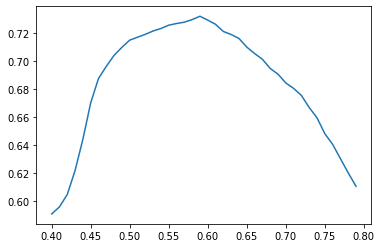

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6647109874994028 using the validated threshold of 0.5900000000000002 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7693014391519823 using a threshold of 0.5900000000000002 

The max weighted f1 score is 0.7114200091758345 with a threshold of 0.5000000000000001 



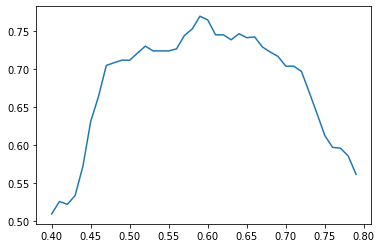

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6430287940209866 using a threshold of 0.5 

The weighted f1 score is 0.6916685823754789 using the validated threshold of 0.5900000000000002 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_100, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()


distilbert-base-uncased:NER:overlap0:MaxLen512:pretrainedOnGuarro&Maharjan&Genre:single_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-11etyczm:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: book_title, token_type_ids, genre.
***** Running Prediction *****
  Num examples = 4737
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: book_title, token_type_ids, genre.
***** Running Prediction *****
  Num examples = 9758
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7127524899313542 using a threshold of 0.5000000000000001 

The max weighted f1 score is 0.7127524899313542 with a threshold of 0.5000000000000001 



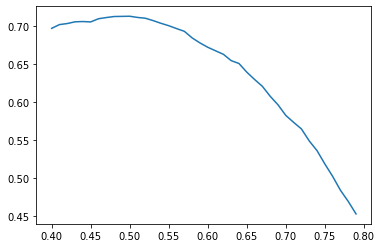

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6742763224069743 using the validated threshold of 0.5000000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7415156973475475 using a threshold of 0.45000000000000007 

The max weighted f1 score is 0.733107294069051 with a threshold of 0.5000000000000001 



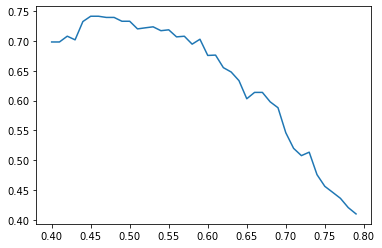

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6898377173060246 using a threshold of 0.5 

The weighted f1 score is 0.6791347087906512 using the validated threshold of 0.45000000000000007 



In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset_single, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments40:pretrainedOnGuarro&Maharjan:multi_task

In [39]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-31b6wr0d:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-31b6wr0d:v0, 255.48MB. 3 files... Done. 0:0:0
loading configuration file ./artifacts/model-31b6wr0d:v0/config.json
Model config DistilBertConfig {
  "_name_or_path": "./artifacts/model-ukrei3n1:v0",
  "activation": "gelu",
  "alpha": 0.5,
  "architectures": [
    "DistilBERTForMultipleSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30523
}

loading weights file ./artifacts/model-31b6wr0d:v0/pytorch_model.bin


2 8


All model checkpoint weights were used when initializing DistilBERTForMultipleSequenceClassification.

All the weights of DistilBERTForMultipleSequenceClassification were initialized from the model checkpoint at ./artifacts/model-31b6wr0d:v0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBERTForMultipleSequenceClassification for predictions without further training.


In [40]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4974
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 10269
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7316631276658343 using a threshold of 0.5400000000000001 

The max weighted f1 score is 0.7245479952249382 with a threshold of 0.5000000000000001 



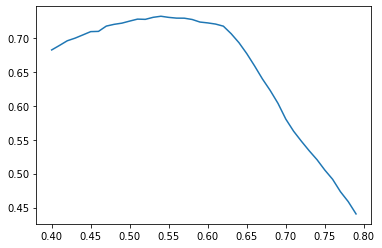

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6870727997559485 using the validated threshold of 0.5400000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7674349152193027 using a threshold of 0.5000000000000001 

The max weighted f1 score is 0.7674349152193027 with a threshold of 0.5000000000000001 



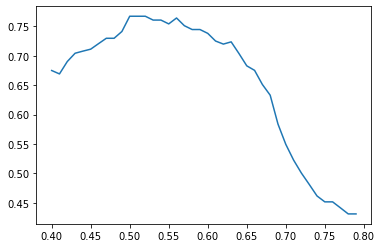

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6777440261218028 using a threshold of 0.5 

The weighted f1 score is 0.6777440261218028 using the validated threshold of 0.5000000000000001 



In [45]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments35:pretrainedOnGuarro&Maharjan:multi_task


In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3ikh50uz:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

In [60]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 4974
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 10269
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.716502010630353 using a threshold of 0.5300000000000001 

The max weighted f1 score is 0.7119851325013785 with a threshold of 0.5000000000000001 



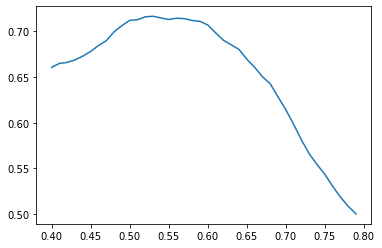

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6532332425636754 using the validated threshold of 0.5300000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7710120827896271 using a threshold of 0.5700000000000002 

The max weighted f1 score is 0.7362663715181701 with a threshold of 0.5000000000000001 



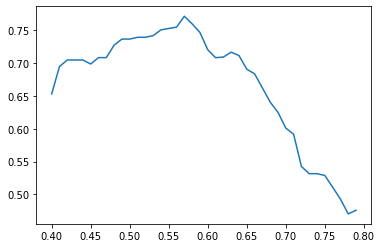

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6450603122459407 using a threshold of 0.5 

The weighted f1 score is 0.6613170476330154 using the validated threshold of 0.5700000000000002 



In [56]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments30:pretrainedOnGuarro&Maharjan:multi_task

In [49]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-24er27bk:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-24er27bk:v0, 255.48MB. 3 files... Done. 0:0:0
loading configuration file ./artifacts/model-24er27bk:v0/config.json
Model config DistilBertConfig {
  "_name_or_path": "./artifacts/model-ukrei3n1:v0",
  "activation": "gelu",
  "alpha": 0.5,
  "architectures": [
    "DistilBERTForMultipleSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30523
}

loading weights file ./artifacts/model-24er27bk:v0/pytorch_model.bin


2 8


All model checkpoint weights were used when initializing DistilBERTForMultipleSequenceClassification.

All the weights of DistilBERTForMultipleSequenceClassification were initialized from the model checkpoint at ./artifacts/model-24er27bk:v0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBERTForMultipleSequenceClassification for predictions without further training.


In [50]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4974
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 10269
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7335726214173237 using a threshold of 0.5500000000000002 

The max weighted f1 score is 0.7235511034479082 with a threshold of 0.5000000000000001 



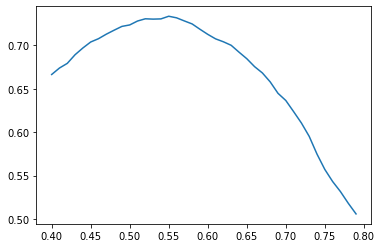

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6738311667015491 using the validated threshold of 0.5500000000000002 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7725748648304722 using a threshold of 0.5800000000000002 

The max weighted f1 score is 0.7263107383679916 with a threshold of 0.5000000000000001 



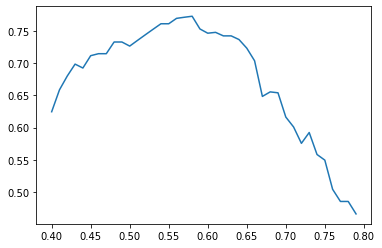

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6835856170389146 using a threshold of 0.5 

The weighted f1 score is 0.7028167235063788 using the validated threshold of 0.5800000000000002 



In [51]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments25:pretrainedOnGuarro&Maharjan:multi_task

In [57]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-325creqa:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

wandb: Downloading large artifact model-325creqa:v0, 255.48MB. 3 files... Done. 0:0:0
loading configuration file ./artifacts/model-325creqa:v0/config.json
Model config DistilBertConfig {
  "_name_or_path": "./artifacts/model-ukrei3n1:v0",
  "activation": "gelu",
  "alpha": 0.5,
  "architectures": [
    "DistilBERTForMultipleSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",
  "vocab_size": 30523
}

loading weights file ./artifacts/model-325creqa:v0/pytorch_model.bin


2 8


All model checkpoint weights were used when initializing DistilBERTForMultipleSequenceClassification.

All the weights of DistilBERTForMultipleSequenceClassification were initialized from the model checkpoint at ./artifacts/model-325creqa:v0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBERTForMultipleSequenceClassification for predictions without further training.


In [58]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 4974
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 10269
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7202274505208462 using a threshold of 0.5000000000000001 

The max weighted f1 score is 0.7202274505208462 with a threshold of 0.5000000000000001 



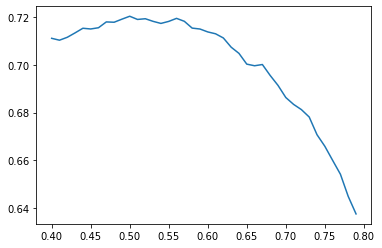

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6736582234158446 using the validated threshold of 0.5000000000000001 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7697841726618705 using a threshold of 0.6000000000000002 

The max weighted f1 score is 0.7438379193552376 with a threshold of 0.5000000000000001 



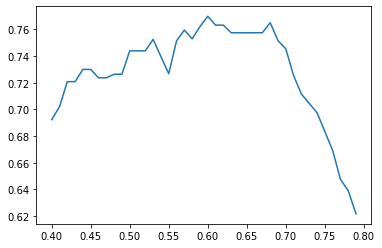

*****SCORE ON TEST SET*****
The weighted f1 score is 0.689184565008225 using a threshold of 0.5 

The weighted f1 score is 0.6989768851837819 using the validated threshold of 0.6000000000000002 



In [59]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

distilbert-base-uncased:NER:overlap25:MaxLen512:MaxSegments20:pretrainedOnGuarro&Maharjan:multi_task

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3k0v2mfk:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

In [47]:
trainer = Trainer(
    model=model
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 4974
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 10269
  Batch size = 8


Getting predictions on test set
*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7338578513553428 using a threshold of 0.5900000000000002 

The max weighted f1 score is 0.7188472238838228 with a threshold of 0.5000000000000001 



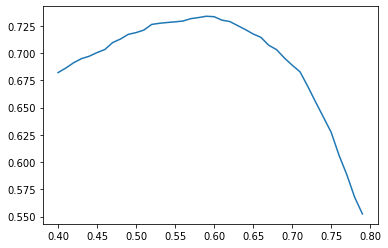

*****SCORE ON TEST SET*****
The weighted f1 score is 0.677537012237204 using the validated threshold of 0.5900000000000002 

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The weighted f1 score is 0.7791724067554465 using a threshold of 0.5900000000000002 

The max weighted f1 score is 0.7326425379718784 with a threshold of 0.5000000000000001 



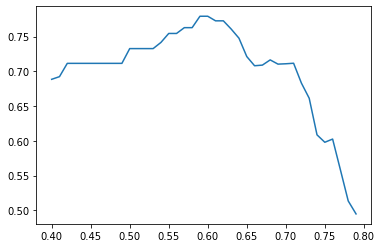

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6672567330792435 using a threshold of 0.5 

The weighted f1 score is 0.6849310659198711 using the validated threshold of 0.5900000000000002 



In [48]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

##### distilroberta scorers

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-3iduae7r:v0', type='model')
artifact_dir = artifact.download()
model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

##### electra score

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor_80_20/model-n03c6uv6:v0', type='model')
artifact_dir = artifact.download()
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
trainer = Trainer(
    model=model
)

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=False)
m_scorer.get_segmented_f1_scores()
m_scorer.get_book_f1_scores()

# Hyperparameter Tuning

multitask hyperparameter tuning

In [ ]:
# saves our models to artifacts in WandB
%env WANDB_LOG_MODEL=true
wandb.login()
# %env WANDB_PROJECT=

In [ ]:
chunked_encoded_dataset

In [ ]:
def compute_metrics_single(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def compute_metrics_multi(pred):
    preds = pred.predictions
    label_ids = pred.label_ids

    success_labels = label_ids[:, 0]
    genre_labels = label_ids[:, 1]

    success_preds = preds[:, 0:2].argmax(1)
    genre_preds = preds[:, 2:6].argmax(1)

    s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
    s_acc = accuracy_score(success_labels, success_preds)

    g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
    g_acc = accuracy_score(success_labels, success_preds)

    return {
        's_accuracy': s_acc,
        's_f1': s_f1,
        's_precision': s_precision,
        's_recall': s_recall,
        'g_accuracy': g_acc,
        'g_f1': g_f1,
        'g_precision': g_precision,
        'g_recall': g_recall
    }

if eval(config['Model']['multi_task']):
  print('multi')
  # from scores import compute_metrics_multi
  compute_metrics = compute_metrics_multi
else:
  print('single')
  # from scores import compute_metrics_single
  compute_metrics = compute_metrics_single

def my_objective(metrics):
    # Your elaborate computation here
    if eval(config['Model']['multi_task']):
      return metrics['eval_s_f1']
    else:
      return metrics['eval_f1']

In [ ]:
from transformers import DistilBertConfig
db_config_base = DistilBertConfig.from_pretrained('/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained')
db_config_base.update({'_name_or_path': '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained', 'alpha': 0.2, 'dropout': 0.8})

In [ ]:
db_config_base

In [ ]:
test = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config_base._name_or_path, config = db_config_base)

In [ ]:
from transformers import BertConfig, BertForSequenceClassification, BertModel
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
model_config_base = model.config

In [ ]:
def tune_transformer(num_samples=8, gpus_per_trial=0, smoke_test=False):
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    def get_model(params):
        print("printing params", params)
        db_config = model_config_base
        if params is not None:
          db_config.update({'attention_probs_dropout_prob': params['attention_dropout'], 'hidden_dropout_prob': params['dropout']})
          # db.config.update({'attention_dropout': params['attention_dropout'], 'dropout': params['dropout']})
          # db_config.update({'_name_or_path': '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained', 'alpha': params['alpha'], 'attention_dropout': params['attention_dropout'], 'dropout': params['dropout']})
        return BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)
        # return DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config_base._name_or_path, config = db_config_base)

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        output_dir = '/ckpts',
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        save_steps = 15,
        evaluation_strategy="steps",
        save_total_limit = 2,
        logging_strategy="steps",
        logging_steps=5,
        eval_steps=15,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        num_train_epochs=0.9,  # config
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        logging_dir="./logs",
        skip_memory_metrics=True,
        report_to='wandb')

    tune_config = {
        "attention_dropout": tune.uniform(0.15,0.4),
        "dropout": tune.uniform(0.15, 0.4),
        # "alpha": tune.uniform(0.3,0.7),
        "learning_rate": tune.loguniform(1e-5, 1e-4),
        "per_device_train_batch_size": tune.choice([8]),
        "num_train_epochs": tune.choice([0.9]),
        "wandb": {
            "project": "ThesisExperiments",
            "group": "dataset_selection-standard",
            "api_key": config['WandB']['api_key'],
            "log_config": True
        }
    }

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)
    

    scheduler = MedianStoppingRule(
        time_attr='training_iteration',
        metric='eval_f1',
        mode='max',
        grace_period=100,
        min_samples_required=3,
        min_time_slice=30,
        hard_stop=True
    )

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "dropout": "dropout",
            # "alpha": "alpha",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        },
        metric_columns=[
            "eval_s_accuracy", "eval_loss", "eval_s_f1", "steps", "training_iteration"
        ])

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        compute_objective=my_objective,
        direction="maximize",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 2,
            "gpu": gpus_per_trial
        },
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="eval_f1",
        # checkpoint_at_end=True,
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer",
        loggers=DEFAULT_LOGGERS + (WandbLogger,))
        # time_budget_s=60*60*10) # 10 hours

In [ ]:
tune_transformer(num_samples=4, gpus_per_trial=1, smoke_test=False)
# tune_transformer(num_samples=1, gpus_per_trial=0, smoke_test=True)

In [ ]:
    # scheduler = ASHAScheduler(
    #     metric="eval_s_f1",
    #     mode="max",
    #     max_t=1000,
    #     grace_period=30,
    #     reduction_factor=1.5)

    # scheduler = ASHAScheduler(
    #     metric="eval_s_f1",
    #     mode="max",
    #     max_t=1,
    #     grace_period=1,
    #     reduction_factor=2)

#     from transformers.modeling_outputs import SequenceClassifierOutput
# from torch import nn
# import torch
# from torch.nn import CrossEntropyLoss, MSELoss

# from transformers import DistilBertPreTrainedModel, DistilBertModel
# class DistilBERTForMultipleSequenceClassification(DistilBertPreTrainedModel):
#     def __init__(self, config, num_labels1 = 2, num_labels2 = 8):
#         super().__init__(config)
#         self.num_labels1 = num_labels1
#         self.num_labels2 = num_labels2
#         print(self.num_labels1, self.num_labels2)
#         self.alpha = config.alpha
#         self.config = config

#         self.distilbert = DistilBertModel(config)
#         self.pre_classifier = nn.Linear(config.dim, config.dim)
#         self.classifier1 = nn.Linear(config.dim, self.num_labels1)
#         self.classifier2 = nn.Linear(config.dim, self.num_labels2)
#         self.dropout = nn.Dropout(config.dropout)

#         self.init_weights()


#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         head_mask=None,
#         inputs_embeds=None,
#         labels=None,
#         output_attentions=None,
#         output_hidden_states=None,
#         return_dict=None,
#     ):
#         r"""
#         labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
#             Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
#             config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
#             If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
#         """
#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

#         distilbert_output = self.distilbert(
#               input_ids=input_ids,
#               attention_mask=attention_mask,
#               head_mask=head_mask,
#               inputs_embeds=inputs_embeds,
#               output_attentions=output_attentions,
#               output_hidden_states=output_hidden_states,
#               return_dict=return_dict,
#           )
#         hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
#         pooled_output = hidden_state[:, 0]  # (bs, dim)
#         pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
#         pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
#         pooled_output = self.dropout(pooled_output)  # (bs, dim)
#         logits1 = self.classifier1(pooled_output)
#         logits2 = self.classifier2(pooled_output)
#         logits = torch.cat([logits1, logits2], 1)

#         loss = None
#         if labels is not None:
#             #if self.config.problem_type is None:
#             #self.config.problem_type = "single_label_classification"
            
#             if self.num_labels1 > 1:
#                 loss_fct1 = CrossEntropyLoss()
#                 loss1 = loss_fct1(logits1.view(-1, self.num_labels1), labels[:, 0].view(-1))
#             else:
#                 loss_fct1 = MSELoss()
#                 loss1 = loss_fct1(logits1.view(-1), labels[:, 0].view(-1))

#             if self.num_labels2 > 1:
#                 loss_fct2 = CrossEntropyLoss()
#                 loss2 = loss_fct2(logits2.view(-1, self.num_labels2), labels[:, 1].view(-1))
#             else:
#                 loss_fct2 = MSELoss()
#                 loss2 = loss_fct2(logits2.view(-1), labels[:, 1].view(-1))
#             loss = self.alpha*loss1 + (1-self.alpha)*loss2 

#         if not return_dict:
#             output = (logits,) + outputs[2:] #not sure if this works
#             return ((loss,) + output) if loss is not None else output

#         return SequenceClassifierOutput(
#             loss=loss,
#             logits=logits,
#             hidden_states=distilbert_output.hidden_states, #hidden_states,
#             attentions=distilbert_output.attentions, #attentions,
#         )

#####standard hyperparameter tuning

In [ ]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
wandb.login()

In [ ]:
import os
import pickle

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining
from transformers import AutoConfig, \
    AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, BertTokenizer, BertForSequenceClassification

In [ ]:
model_name = 'bert-base-uncased'

In [ ]:
project_name = "BERT-base-uncased-HP-Tuning"
%env WANDB_PROJECT=BERT-base-uncased-HP-Tuning

In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def tune_transformer(num_samples=8,
                     gpus_per_trial=0,
                     smoke_test=False,
                     ray_address=None):
    ray.init(ray_address, log_to_driver=True)
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    # Change these as needed.
    # model_name = 'google/electra-small-discriminator' if not smoke_test \
    #     else 'google/electra-small-discriminator'
    task_name = "grs"

    task_data_dir = os.path.join(data_dir, task_name.upper())

    num_labels = 2

    # config = AutoConfig.from_pretrained(
    #     model_name, num_labels=num_labels, finetuning_task=task_name)

    # Download and cache tokenizer, model, and features
    print("Downloading and caching Tokenizer")
    # tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-small-discriminator', additional_special_tokens = ['[CHARACTER]'])
    tokenizer = BertTokenizer.from_pretrained(model_name, additional_special_tokens = ['[CHARACTER]'])
    
    # Triggers tokenizer download to cache
    # print("Downloading and caching pre-trained model")
    # AutoModelForSequenceClassification.from_pretrained(
    #     model_name,
    #     config=config,
    # )

    def get_model():
        # model = ElectraForSequenceClassification.from_pretrained('/content/drive/MyDrive/Thesis/Models/ELECTRA_small_pretrained', num_labels=2)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model.resize_token_embeddings(len(tokenizer))
        return model

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        project_name,
        # output_dir=".",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=2,  # config
        max_steps=-1,
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        # logging_dir="./logs",
    )

    training_args._n_gpu = gpus_per_trial

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)

    tune_config = {
        # "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 32,
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
        "wandb": {
            "project": project_name,
            "api_key": config['WandB']['api_key'],
            "log_config": True
        }
    }

    scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_f1",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            "weight_decay": tune.uniform(0.0, 0.3),
            "warmup_steps": tune.choice([0, 50, 100, 500, 1000]),
            "learning_rate": tune.uniform(1e-5, 4e-5),
            "per_device_train_batch_size": [8, 16],
        })

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        })

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 1,
            "gpu": gpus_per_trial
        },
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        # log_to_file=True,
        loggers=DEFAULT_LOGGERS + (WandbLogger, ),
        time_budget_s=60*15
    )

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument(
    "--smoke-test", action="store_true", help="Finish quickly for testing")
parser.add_argument(
    "--ray-address",
    type=str,
    default=None,
    help="Address to use for Ray. "
    "Use \"auto\" for cluster. "
    "Defaults to None for local.")
args, _ = parser.parse_known_args()

if args.smoke_test:
    tune_transformer(
        num_samples=1,
        gpus_per_trial=0,
        smoke_test=True,
        ray_address=args.ray_address)
else:
    # You can change the number of GPUs here:
    tune_transformer(
        num_samples=15, gpus_per_trial=1, ray_address=args.ray_address)

In [ ]:
ray.shutdown()

# UNNEEDED CODE

In [ ]:
def tokenize_w_overlap(example, tokenizer, chunk_len = 512, overlap_len = 50):
    data_tokenize = tokenizer(example['text'], 
                    max_length = chunk_len,
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=True,
                    return_overflowing_tokens = True,
                    return_tensors = 'np')

    long_terms_token = []
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = []
    targets_list = []

    previous_input_ids = data_tokenize["input_ids"].reshape(-1)
    previous_attention_mask = data_tokenize["attention_mask"].reshape(-1)
    previous_token_type_ids = data_tokenize["token_type_ids"].reshape(-1)
    remain = data_tokenize["overflowing_tokens"].reshape(-1)
    
    input_ids_list.append(previous_input_ids)
    attention_mask_list.append(previous_attention_mask)
    token_type_ids_list.append(previous_token_type_ids)

    if remain is not None:
      idxs = range(len(remain)+chunk_len)
      idxs = idxs[(chunk_len-overlap_len-2)
                    ::(chunk_len-overlap_len-2)]
      input_ids_first_overlap = previous_input_ids[-(
          overlap_len+1):-1]
      start_token = np.array([101])
      end_token = np.array([102])

      for i, idx in enumerate(idxs):
          if i == 0:
              input_ids = np.concatenate((input_ids_first_overlap, remain[:idx])) # building the 2nd chunk
          elif i == len(idxs):
              input_ids = remain[idx:]
          elif previous_idx >= len(remain):
              break
          else:
              input_ids = remain[(previous_idx-overlap_len):idx]

          previous_idx = idx

          nb_token = len(input_ids)+2
          attention_mask = np.ones(chunk_len)
          attention_mask[nb_token:chunk_len] = 0 # only will take effect on the last chunk
          token_type_ids = np.zeros(chunk_len)
          input_ids = np.concatenate((start_token, input_ids, end_token))

          if chunk_len-nb_token > 0: # add padding, only can pass on last chunk
              padding = np.zeros(chunk_len-nb_token)
              input_ids = np.concatenate((input_ids, padding))

          input_ids_list.append(input_ids)
          attention_mask_list.append(attention_mask)
          token_type_ids_list.append(token_type_ids)

      print(input_ids_list)

      return {
          'input_ids': input_ids_list,  # torch.tensor(ids, dtype=torch.long),
          'attention_mask': attention_mask_list,
          'token_type_ids': token_type_ids_list,
          'success_label': np.array([example['success_label']] * len(input_ids_list)),
          'genre': np.array([example['genre']] * len(input_ids_list))
          # 'len': [np.array(len(targets_list), dtype=torch.long)]
      }

In [ ]:
# When batched = True, we take in multiple examples
def chunk_and_encode_examples_w_overlap(examples):
  mega_dict = {'attention_mask': [], 'genre': [], 'input_ids': [], 'success_label': [], 'token_type_ids': [], 'book_title': []}
  for i in range(len(examples['text'])):
    book_sample = {'text': examples['text'][i], 'genre': examples['genre'][i], 'success_label': examples['success_label'][i], 'book_title':examples['book_title'][i]}
    dictOfTokenizedChunks = tokenize_w_overlap(book_sample, tokenizer)
    for key, value in dictOfTokenizedChunks.items():
      mega_dict[key].extend(value)
  return mega_dict

In [ ]:
!transformers-cli env

In [ ]:
from transformers import DistilBertModel
import torch

run = wandb.init()
artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-3vvi0uoq:v0', type='model')
artifact_dir = artifact.download()
db_model = DistilBertModel.from_pretrained(artifact_dir)

db_model.save_pretrained('/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/3vvi0uoqDistilBertModel')